In [1]:
from main import setup
import yaml
import pathlib
import torch
import matplotlib.pyplot as plt

INFO:2024-01-14 21:57:56 3847:3847 init.cpp:158] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti


In [2]:
def load(path, episode):
    hparam = path + "/hparam.yaml"
    config = yaml.safe_load(open(hparam))
    sampler, optim, scheduler = setup(config)

    progress = torch.load(f"{path}/progress{'_' + str(episode) if episode != None else ''}.pth")

    if "ln_a_0" in progress["sampler"]:
        del progress["sampler"]["ln_a_0"]
    
    if "ln_a_1" in progress["sampler"]:
        del progress["sampler"]["ln_a_1"]

    sampler.load_state_dict(progress["sampler"])
    optim.load_state_dict(progress["optim"])

    return config, sampler, optim


In [3]:
from mcmd.densities import DoubleWell


log_norm = DoubleWell(5, 5, 4).log_norm()

In [15]:
ln_rnd = torch.tensor([0, 1.0, 2.0])
B = ln_rnd.shape[0]
device = ln_rnd.device

torch.vstack([ln_rnd, torch.zeros(B).to(device)])

torch.tensor(2.0).log()
          


TypeError: log(): argument 'input' (position 1) must be Tensor, not int

In [4]:
config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/24-01-08-16:56:25", None)
samples = sampler.sample(3000, loss_fn="mean", repel=True, a=0.0)
config['loss_fn'], config['repel'], samples.ln_z, samples.jensen(log_norm), samples.elbo


('var',
 True,
 tensor(-5.1674, device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0.6924, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-26.2378, device='cuda:0', grad_fn=<MeanBackward0>))

In [5]:
# config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/24-01-08-16:56:25", 2000)
# config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/23-12-31-19:07:06", None)
config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/23-12-25-22:14:27", None)
samples2 = sampler.sample(3000, loss_fn="mean", repel=False, a=None)
config['loss_fn'], config['repel'], samples2.ln_z, samples2.jensen(log_norm)


('var',
 False,
 tensor(-42.7241, device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0.6931, device='cuda:0', grad_fn=<MeanBackward0>))

In [8]:
# config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/24-01-01-02:15:38", None)
# config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/24-01-01-22:38:49", None)
config, sampler, optim = load("/home/brianlck/code/code/dissertation/logs/dw/23-12-26-05:53:23",  None)
samples3 = sampler.sample(50000, loss_fn="mean", a=None, repel=False)
config['loss_fn'], config['repel'], samples3.ln_z, samples3.jensen(log_norm), samples3.elbo


('mean',
 False,
 tensor(-2.9217, device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0.6215, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(-4.9210, device='cuda:0', grad_fn=<MeanBackward0>))

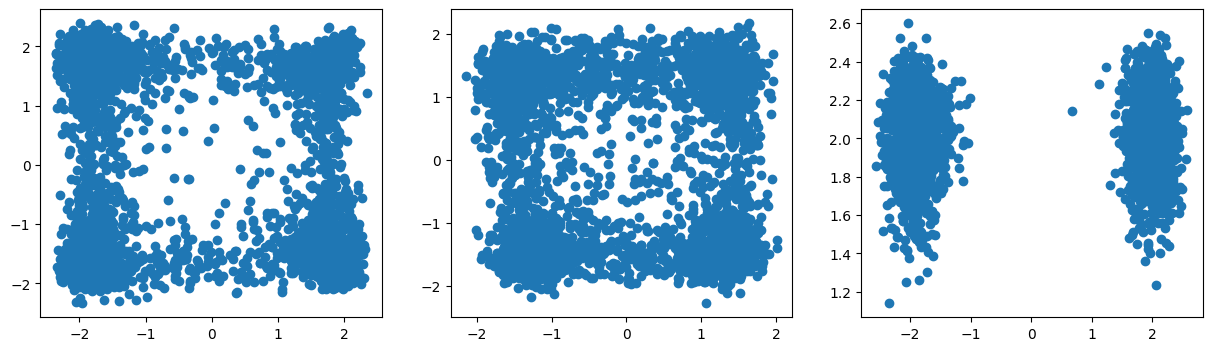

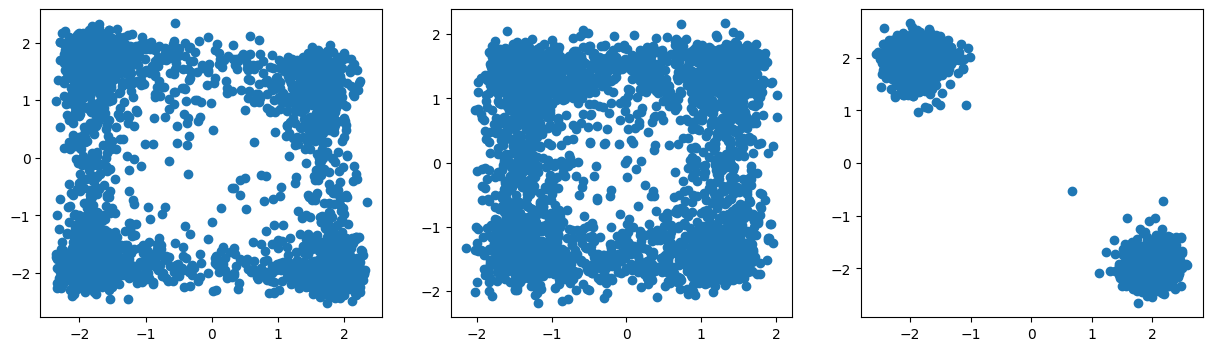

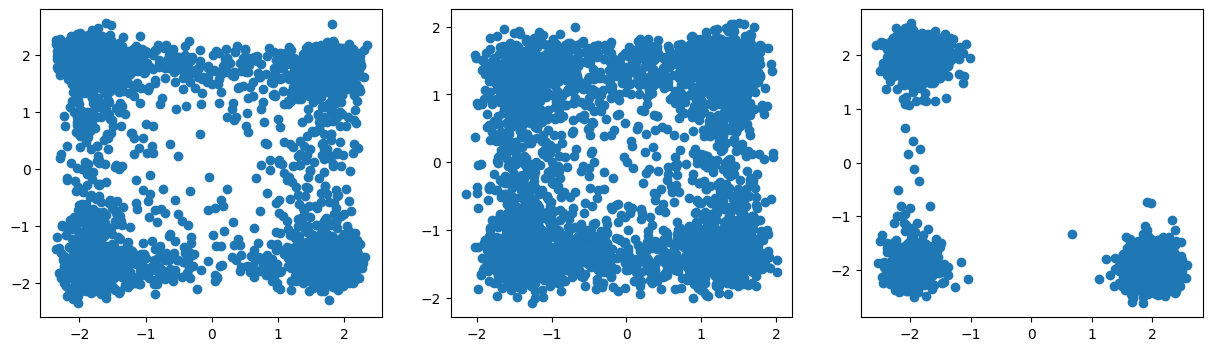

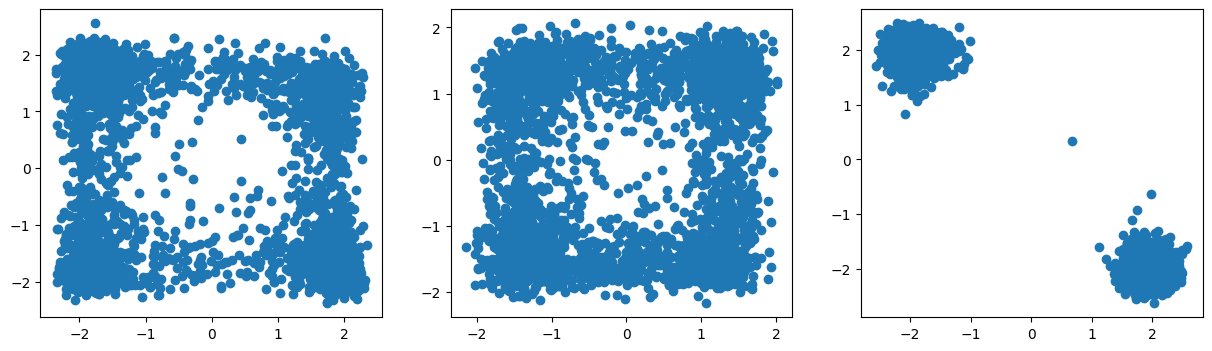

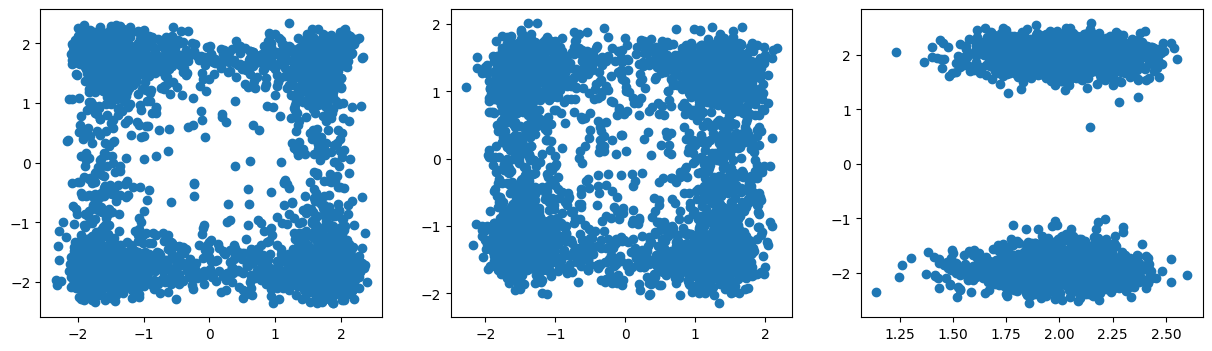

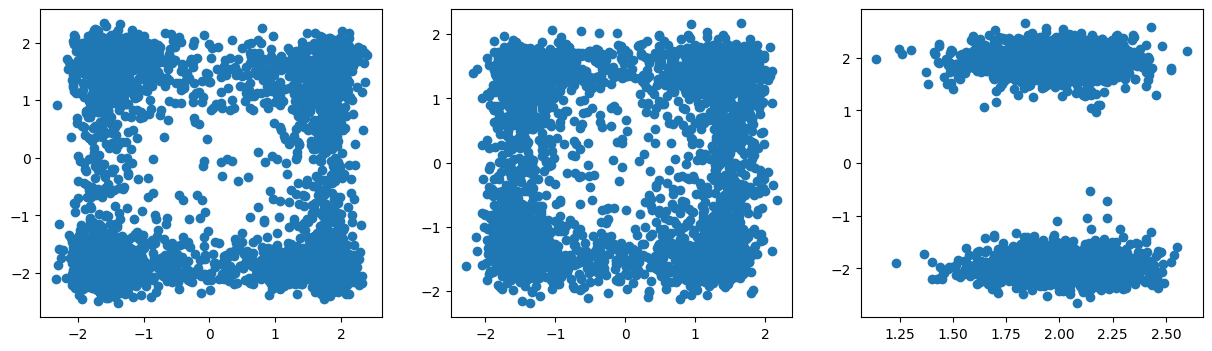

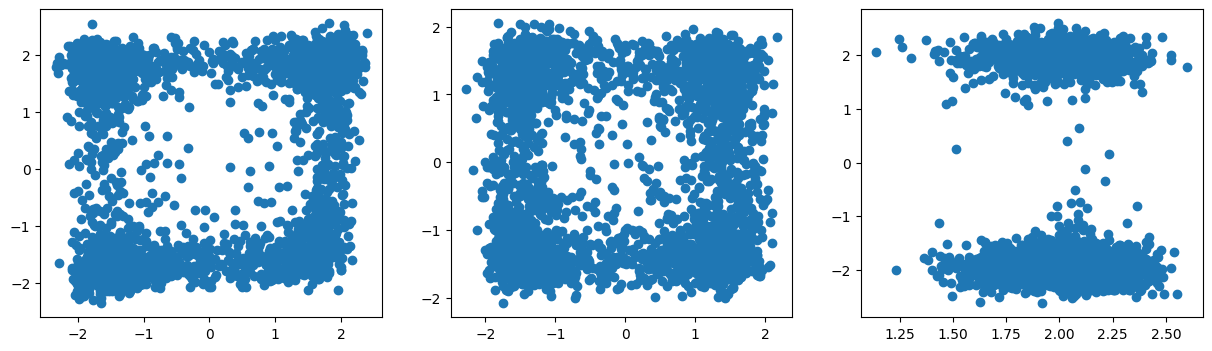

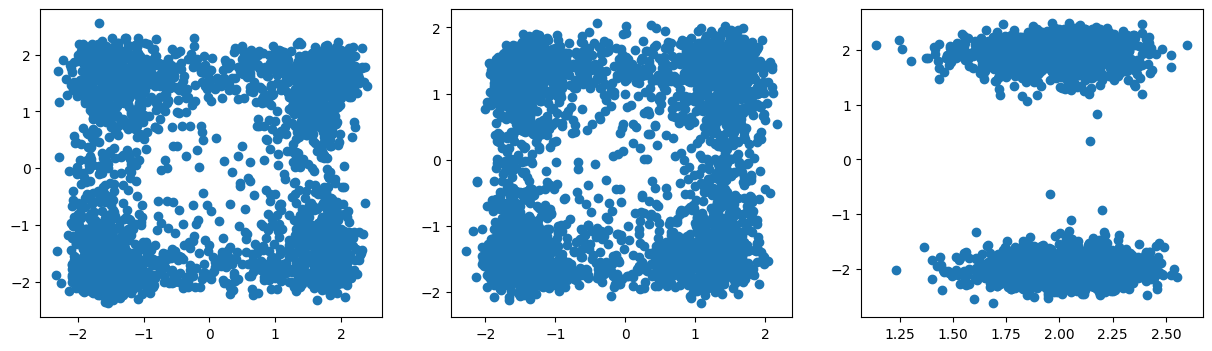

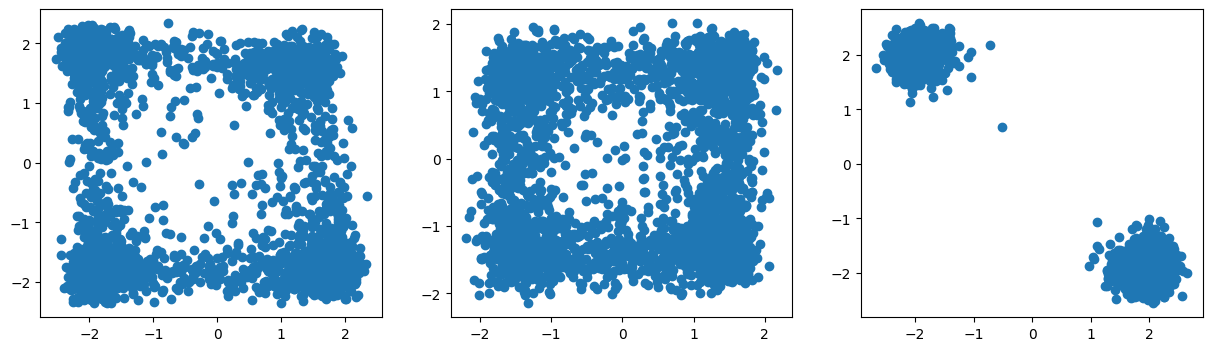

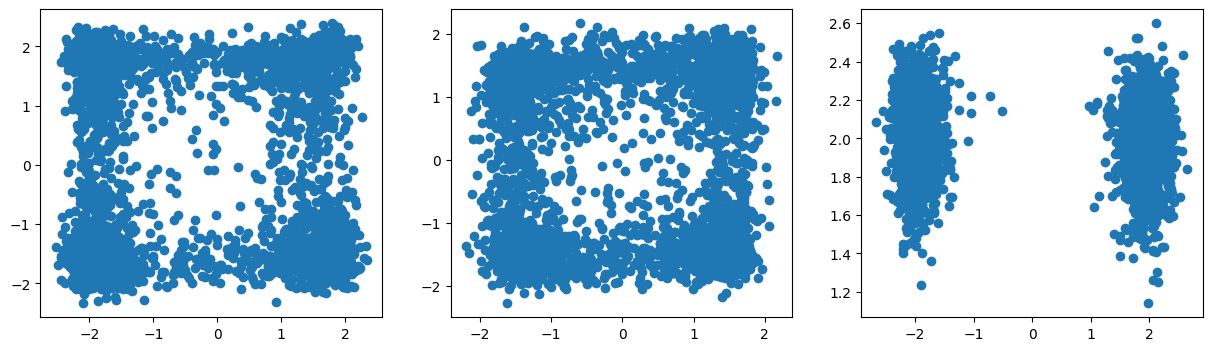

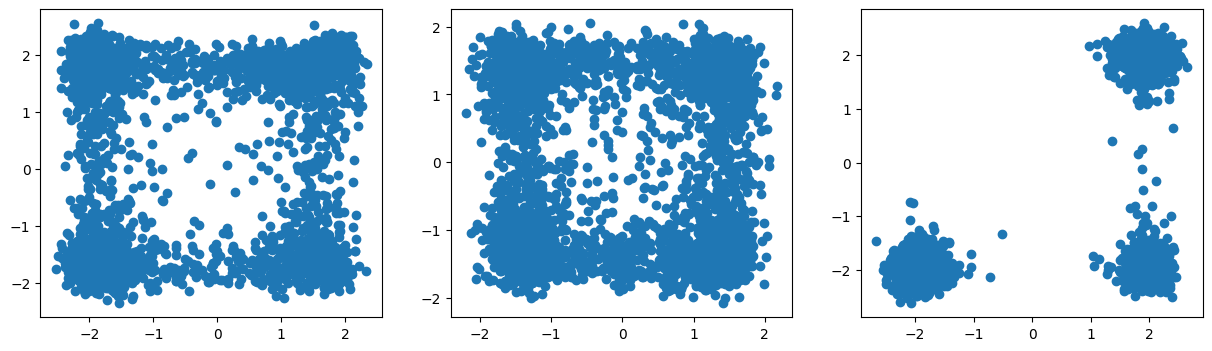

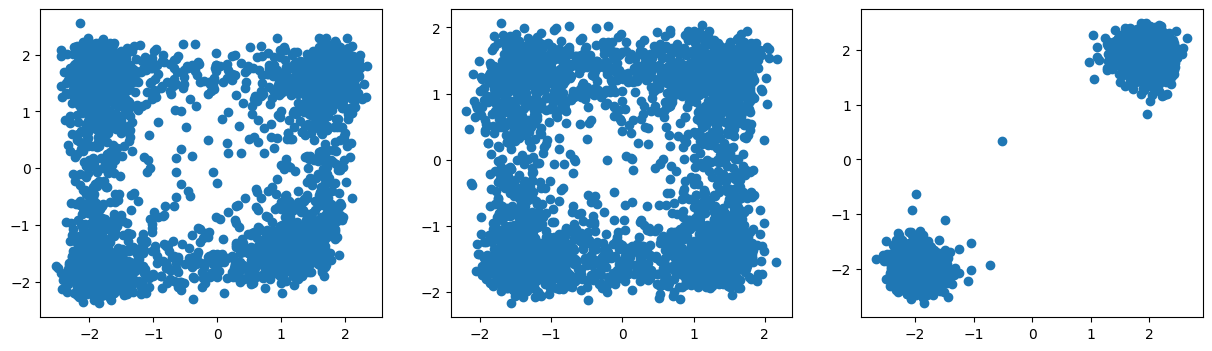

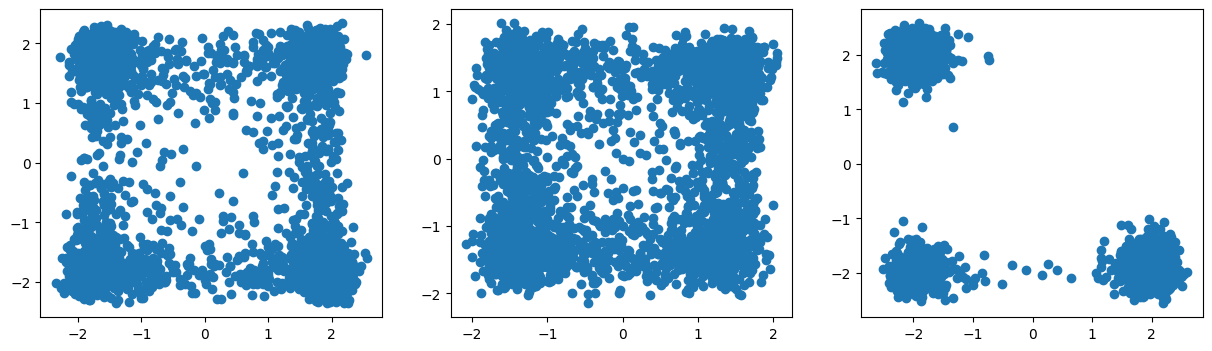

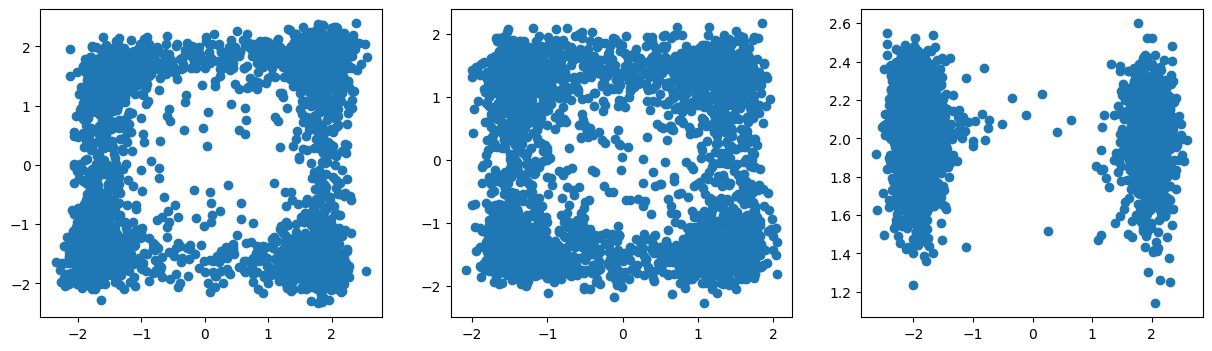

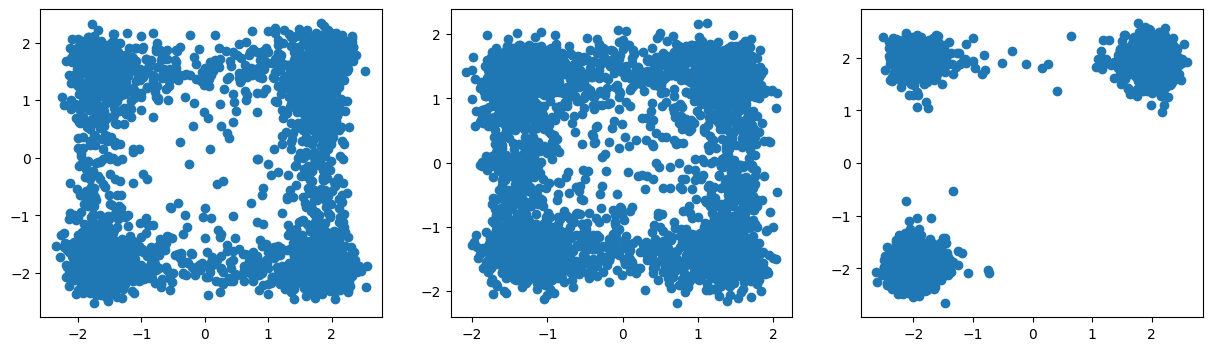

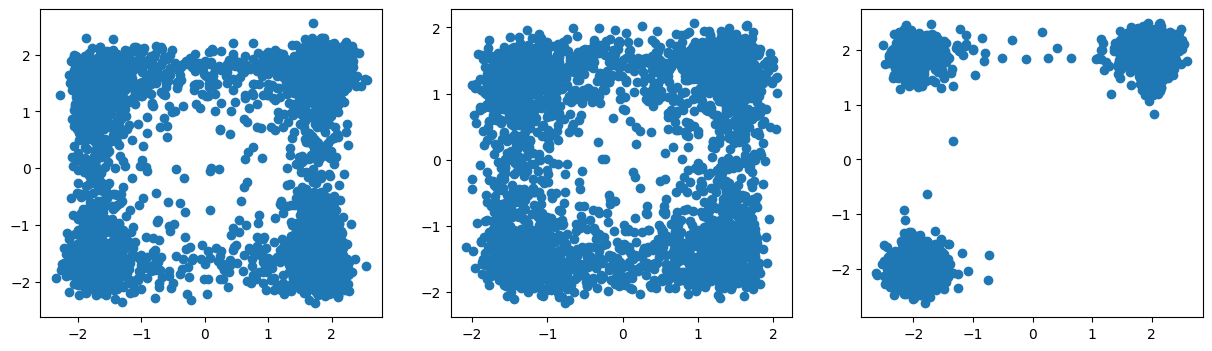

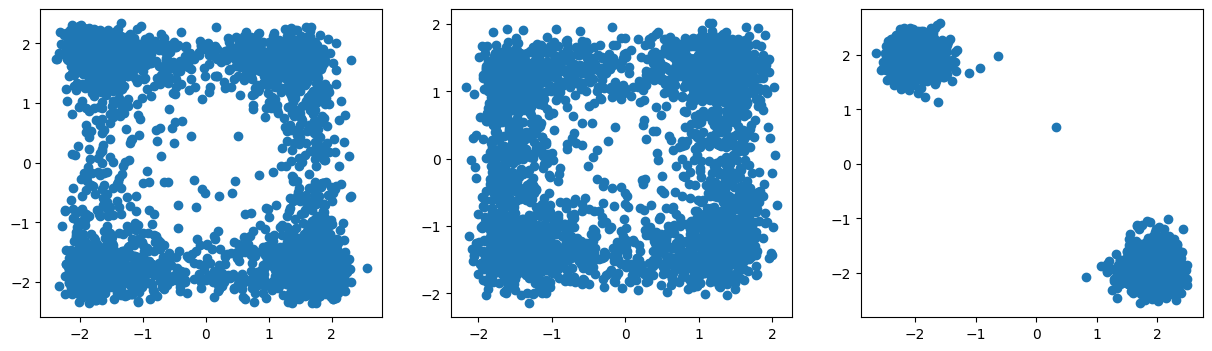

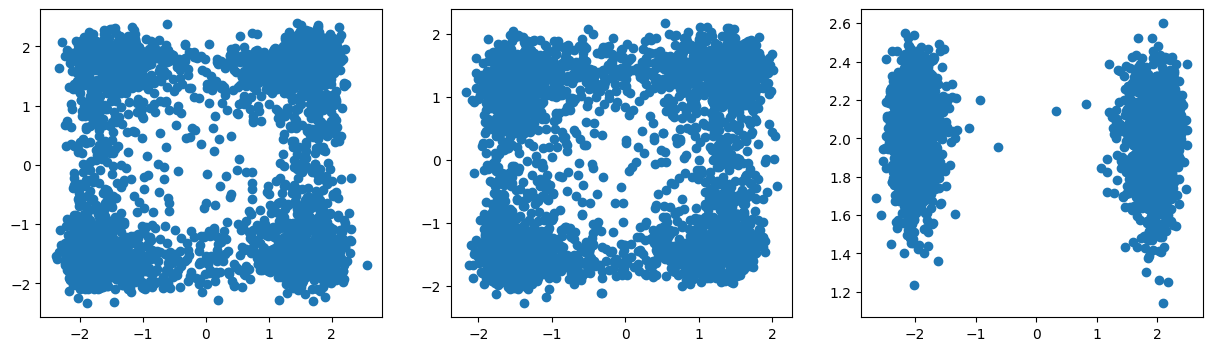

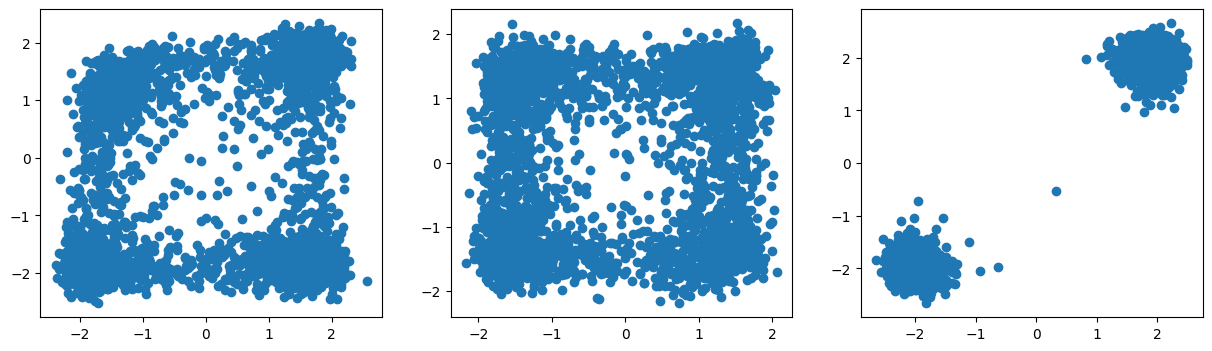

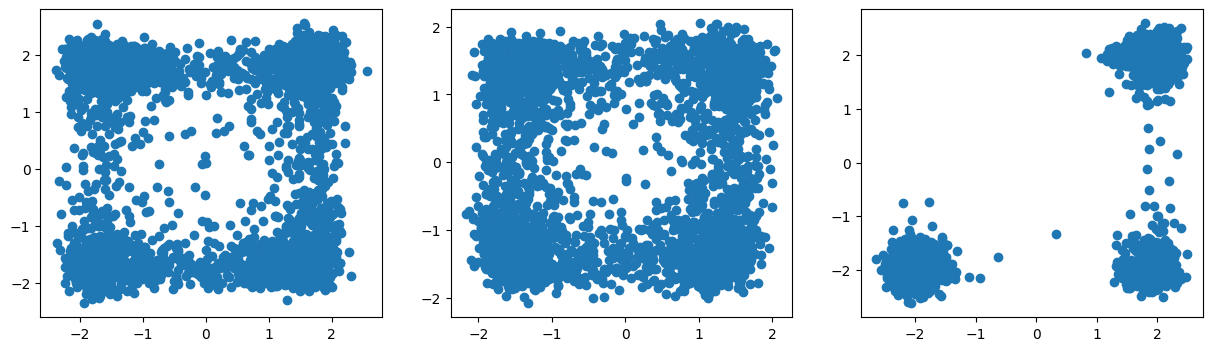

In [12]:
for i in range(5):
    for j in range(5):
        if i != j:
            fig = plt.figure(3, figsize=(15,4))
            subfig = fig.subplots(1, 3)
            subfig[0].scatter(samples.particles[:, i].detach().cpu().numpy(), samples.particles[:, j].detach().cpu().numpy())
            subfig[1].scatter(samples2.particles[:, i].detach().cpu().numpy(), samples2.particles[:, j].detach().cpu().numpy())
            subfig[2].scatter(samples3.particles[:, i].detach().cpu().numpy(), samples3.particles[:, j].detach().cpu().numpy())
            plt.show()